# Intro to Deep Learning


**Deep learning** is a category of **machine learning**. Machine learning is a category of **artificial intelligence**. These notes are mostly about deep learning, thus the name of the book. Deep learning is the use of neural networks to classify and regress data. I am a chemical engineering professor though; writing an introduction to deep learning is a hopeless task for me. I found the introduction the from [Ian Goodfellow's book](https://www.deeplearningbook.org/contents/intro.html) to be a good intro. If you're more visually oriented, Grant Sanderson has made a [short video series](https://www.youtube.com/watch?v=aircAruvnKk) specifically about neural networks that give an applied introduction to the topic. DeepMind has a high-level video showing what can be accomplished with [deep learning & AI](https://www.youtube.com/watch?v=7R52wiUgxZI). When people write "deep learning is really cool" in their research papers, they typically cite [this Nature paper](https://www.nature.com/articles/nature14539) by Yann LeCun, Yoshua Bengio, and Geoffery Hinton. Zhang, Lipton, Li, and Smola have written a practical and example-driven [online book](http://d2l.ai/index.html) that gives each example in Tensorflow, PyTorch, and MXNet.

The main advice I would give to beginners in deep learning are to focus less on the neurological inspired language (i.e., connections between neurons), and instead view deep learning as a series of linear algebra operations where many of the matrices are filled with adjustable parameters. There are of course a few non-linear functions (activations) here and there, but deep learning is essentially linear algebra operations specified via a graph (network kind) that vaguely looks like neurons in a brain.


## Neural Networks

The *deep* in deep learning means we have many layers in our neural networks. What is a neural network? Without loss of generality, we can view neural networks as 2 components: (1) a non-linear function $g(\cdot)$ which operates on our input features $\mathbf{X}$ and outputs a new set of features $\mathbf{H} = g(\mathbf{X})$ and (2) a linear model like we saw in our Machine Learning chapter. Our model equation for deep learning regression is:

\begin{equation}
    y = \vec{w}g(\vec{x}) + b
\end{equation}

One of the main discussion points in our ML chapters was how arcane and difficult it is to choose features. Here, we have replaced our features with a set of trainable features $g(\vec{x})$ and then use the same linear model as before. So how do we design $g(\vec{x})$? That is the deep learning part. $g(\vec{x})$ is a differentiable function we design composed of **layers**, which are themselves differentiable functions each with trainable weights (variables). Deep learning is a mature field and there is a set of standard layers, each with a different purpose. For example, convolution layers look at a fixed neighborhood around each element of an input tensor. Dropout layers randomly inactivate inputs as a form of regularization. The most commonly used and basic layer is the **dense** or **fully-connected** layer.

```{margin}
Dense means each input element affects each output element. At one point, sparse layers were popular and had a nice analogy with how a brain is connected. However, dense layers do not require deciding which input/output connections to make and sparse layers are very rare now (except incidentally sparse layers, like convolutions).
```

A dense layer is defined by two things: the desired output feature shape and the **activation**. The equation is:

\begin{equation}
     \vec{h} = \sigma(\mathbf{W}\vec{x} + \vec{b})
\end{equation}

where $\mathbf{W}$ is a trainable $D \times F$ matrix, where $D$ is the input vector ($\vec{x}$) dimension and $F$ is the output vector ($\vec{h}$) dimension, $\vec{b}$ is a trainable $F$ dimensional vector, and $\sigma(\cdot)$ is the activation function. $F$ is an example of a **hyperparameter**, it is not trainable but is a problem dependent choice. $\sigma(\cdot)$ is another hyperparameter. In principle, any differentiable function that has a range of $(-\infty, \infty)$ can be used for activation. However, just a few activations have been empirically designed that balance computational cost and effectiveness. One example we've seen before is the sigmoid. Another is a hyperbolic tangent, which behaves similar (domain/range) to the sigmoid.


## Frameworks


Deep learning has lots of "gotchas" -- easy to make mistakes that make it difficult to implement things yourself. This is especially true with numerical stability, which only reveals itself when your models fails to learn. We will move to a bit of a more abstract software framework than JAX. I may update this, but for now we'll use [Keras](https://keras.io/).

## Discussion

When it comes to introducing deep learning, I will be as terse as possible. There are good learning resources out there. You should use some of the reading above and tutorials put out by Keras (or PyTorch) to get familiar with the concept

## Revisiting Solubity Model

We'll see our first example of deep learning by revisiting the solubility dataset with a two layer dense neural network.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install matplotlib numpy pandas seaborn tensorflow
```

````

The hidden cells below sets-up our imports and/or install necessary packages.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import tensorflow as tf
import numpy as np
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 })
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 

### Load Data

We download the data and load it into a [Pandas](https://pandas.pydata.org/) data frame and then standardize our features as before.

In [3]:
soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
features_start_at = list(soldata.columns).index('MolWt')
feature_names = soldata.columns[features_start_at:]
# standardize the features
soldata[feature_names] -= soldata[feature_names].mean()
soldata[feature_names] /= soldata[feature_names].std()

## Prepare Data for Keras

The deep learning libraries simplify many common tasks, like splitting data and building layers. This code below builds our dataset from numpy arrays. 

In [56]:
full_data = tf.data.Dataset.from_tensor_slices((soldata[feature_names].values, soldata['Solubility'].values))
N = len(soldata)
test_N = int(0.1 * N)
test_data = full_data.take(test_N).batch(16)
train_data = full_data.skip(test_N).batch(16)

Notice that we used `skip` and `take` to split our dataset into two pieces and then created batches of data.

## Neural Network
Now we build our neural network model. In this case, our $g(\vec{x}) = \sigma\left(\mathbf{W^0}\vec{x} + \vec{b}\right)$. We'll choose our activation to be a tanh and a hidden layer dimension of 32. You can read more about this [API here](https://keras.io/guides/sequential_model/), however you should be able to understand the process from the function names and comments.

In [116]:
# our hidden layer
# We only need to define the output dimension - 32.
hidden_layer =  tf.keras.layers.Dense(32, activation='tanh')
# Last layer - which we want to output one number
# the predicted solubility. 
output_layer = tf.keras.layers.Dense(1)

# Now we put the layers into a sequential model
model = tf.keras.Sequential()
model.add(hidden_layer)
model.add(output_layer)

# our model is complete

# Try out our model on first few datapoints
model(soldata[feature_names].values[:3])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[ 0.1746186],
       [-0.4963269],
       [-0.6331892]], dtype=float32)>

We can see our model predicting the solubility for 3 molecules above. There is a warning about how our Pandas data is using float64 (double precision floating point numbers) but our model is using float32 (single precision), which doesn't matter that much. It warns us because we are technically throwing out a little bit of precision, but our solubility has much more variance than the difference between 32 and 64 bit precision floating point numbers.

At this point, we've defined how our model structure should work and it can be called on data. Now we need to train it! We prepare the model for training by calling `compile`, which is where we define our optimization (flavor of stochastic gradient descent) and loss

In [110]:
model.compile(optimizer='SGD', loss='mean_squared_error')

Look back to the amount of work it took to previously set-up loss and optimization process! Now we can train our model

In [111]:
model.fit(train_data, epochs=50)

Epoch 1/50
562/562 [==============================] - 0s 476us/step - loss: 2.4243
Epoch 2/50
562/562 [==============================] - 0s 520us/step - loss: 1.8550
Epoch 3/50
562/562 [==============================] - 0s 456us/step - loss: 1.7096
Epoch 4/50
562/562 [==============================] - 0s 454us/step - loss: 1.6306
Epoch 5/50
562/562 [==============================] - 0s 462us/step - loss: 1.5806
Epoch 6/50
562/562 [==============================] - 0s 471us/step - loss: 1.5471
Epoch 7/50
562/562 [==============================] - 0s 460us/step - loss: 1.5222
Epoch 8/50
562/562 [==============================] - 0s 451us/step - loss: 1.5022
Epoch 9/50
562/562 [==============================] - 0s 452us/step - loss: 1.4878
Epoch 10/50
562/562 [==============================] - 0s 532us/step - loss: 1.4775
Epoch 11/50
562/562 [==============================] - 0s 449us/step - loss: 1.4658
Epoch 12/50
562/562 [==============================] - 0s 456us/step - loss: 1.4588
E

That was quite simple! For reference, we got a loss about as low as 3 in our previous work. It was also much faster, thanks to the optimizations. Now let's see how our model did on the test data

In [112]:
# get model predictions on test data and get labels
# squeeze to remove extra dimensions
yhat = np.squeeze(model.predict(test_data))
test_y = soldata['Solubility'].values[:test_N]

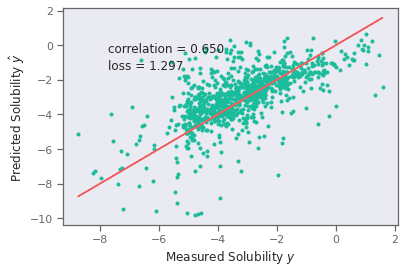

In [113]:
plt.plot(test_y, yhat, '.')
plt.plot(test_y, test_y, '-')
plt.xlabel('Measured Solubility $y$')
plt.ylabel('Predicted Solubility $\hat{y}$')
plt.text(min(test_y) + 1, max(test_y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(test_y) + 1, max(test_y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.show()

This performance is better than our simple linear model. We can see there is some overfitting still. Let's see if we can improve that using regularization. I'll repeat the steps below with a small change to add L2 regularization. See if you can spot the change!

In [114]:
hidden_layer =  tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer='l2')
output_layer = tf.keras.layers.Dense(1)

model = tf.keras.Sequential()
model.add(hidden_layer)
model.add(output_layer)

model.compile(optimizer='SGD', loss='mean_squared_error')
model.fit(train_data, epochs=50)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

562/562 [==============================] - 0s 558us/step - loss: 2.3391
Epoch 2/50
562/562 [==============================] - 0s 453us/step - loss: 1.8441
Epoch 3/50
562/562 [==============================] - 0s 484us/step - loss: 1.7342
Epoch 4/50
562/562 [==============================] - 0s 480us/step - loss: 1.6576
Epoch 5/50
562/562 [==============================] - 0s 477us/step - loss: 1.6001
Epoch 6/50
562/562 [==============================] - 0s 475us/step - loss: 1.5596
Epoch 7/50

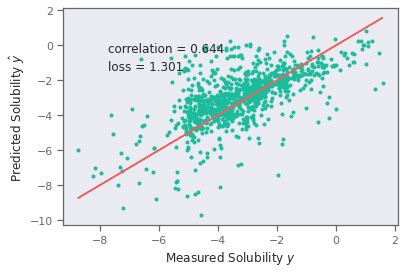

In [115]:
yhat = np.squeeze(model.predict(test_data))
test_y = soldata['Solubility'].values[:test_N]
plt.plot(test_y, yhat, '.')
plt.plot(test_y, test_y, '-')
plt.xlabel('Measured Solubility $y$')
plt.ylabel('Predicted Solubility $\hat{y}$')
plt.text(min(test_y) + 1, max(test_y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(test_y) + 1, max(test_y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.show()

With that change, our test error is improved and matches the training error (the values printed out during training). You can read more about the model training process in [Keras here](https://www.tensorflow.org/guide/keras/train_and_evaluate). You can see that this process is very similar to our ML regression chapter. We use batching, loss, and gradient descent. The only change is the type of model equations. 